<a href="https://colab.research.google.com/github/rai8896/Deep_Learning_Lab/blob/main/DL_Experiment6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!pip install nltk matplotlib seaborn

import torch
import torch.nn as nn
import torch.optim as optim
import random
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from nltk.translate.bleu_score import sentence_bleu
import nltk
nltk.download('punkt')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [24]:
def load_data(path, max_samples=8000):
    pairs = []
    with open(path, encoding='utf-8') as f:
        for line in f.readlines()[:max_samples]:
            eng, spa = line.strip().split('\t')
            pairs.append((eng.lower(), spa.lower()))
    return pairs

pairs = load_data("/content/spa.txt")

print("Total samples:", len(pairs))
print("\nFirst 5 examples:\n")
for i in range(5):
    print("ENG:", pairs[i][0])
    print("SPA:", pairs[i][1])
    print()


Total samples: 8000

First 5 examples:

ENG: go.
SPA: ve.

ENG: go.
SPA: vete.

ENG: go.
SPA: vaya.

ENG: go.
SPA: váyase.

ENG: hi.
SPA: hola.



In [25]:
def tokenize(sentence):
    return re.findall(r"\w+|[^\w\s]", sentence)


In [26]:
class Vocab:
    def __init__(self, sentences):
        counter = Counter()
        for s in sentences:
            counter.update(tokenize(s))

        self.itos = ['<pad>', '<sos>', '<eos>', '<unk>']
        self.stoi = {tok:i for i,tok in enumerate(self.itos)}

        for word in counter:
            self.stoi[word] = len(self.itos)
            self.itos.append(word)

eng_vocab = Vocab([p[0] for p in pairs])
spa_vocab = Vocab([p[1] for p in pairs])

print("English vocab size:", len(eng_vocab.itos))
print("Spanish vocab size:", len(spa_vocab.itos))


English vocab size: 1963
Spanish vocab size: 4073


In [27]:
def numericalize(sentence, vocab):
    tokens = tokenize(sentence)
    return [vocab.stoi.get(t, vocab.stoi['<unk>']) for t in tokens]


In [28]:
class TranslationDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        src, trg = self.pairs[idx]

        src = [eng_vocab.stoi['<sos>']] + numericalize(src, eng_vocab) + [eng_vocab.stoi['<eos>']]
        trg = [spa_vocab.stoi['<sos>']] + numericalize(trg, spa_vocab) + [spa_vocab.stoi['<eos>']]

        return torch.tensor(src), torch.tensor(trg)


In [29]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    src_batch, trg_batch = zip(*batch)
    src_batch = pad_sequence(src_batch, padding_value=0)
    trg_batch = pad_sequence(trg_batch, padding_value=0)
    return src_batch.to(device), trg_batch.to(device)


In [30]:
train_size = int(0.8 * len(pairs))
val_size = int(0.1 * len(pairs))

train_data = TranslationDataset(pairs[:train_size])
val_data = TranslationDataset(pairs[train_size:train_size+val_size])
test_data = TranslationDataset(pairs[train_size+val_size:])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=32, collate_fn=collate_fn)

print("Train size:", len(train_data))
print("Validation size:", len(val_data))
print("Test size:", len(test_data))


Train size: 6400
Validation size: 800
Test size: 800


Part 1: LSTM Encoder-Decoder (No Attention)

In [31]:
class Encoder_v(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, (hidden, cell) = self.lstm(embedded)
        return hidden, cell


Decoder

In [32]:
class Decoder_v(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim)
        self.fc = nn.Linear(hid_dim, output_dim)

    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        embedded = self.embedding(input)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc(output.squeeze(0))
        return prediction, hidden, cell


In [33]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        hidden, cell = self.encoder(src)
        input = trg[0]
        outputs = []

        for t in range(1, trg.shape[0]):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs.append(output)

            teacher_force = random.random() < teacher_forcing_ratio
            input = trg[t] if teacher_force else output.argmax(1)

        return torch.stack(outputs)


In [35]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, (hidden, cell) = self.lstm(embedded)
        return hidden, cell


class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim)
        self.fc = nn.Linear(hid_dim, output_dim)

    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        embedded = self.embedding(input)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc(output.squeeze(0))
        return prediction, hidden, cell


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        hidden, cell = self.encoder(src)
        input = trg[0]
        outputs = []

        for t in range(1, trg.shape[0]):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs.append(output)

            teacher_force = random.random() < teacher_forcing_ratio
            input = trg[t] if teacher_force else output.argmax(1)

        return torch.stack(outputs)


In [36]:
enc_v = Encoder(len(eng_vocab.itos), 256, 512)
dec_v = Decoder(len(spa_vocab.itos), 256, 512)

model_v = Seq2Seq(enc_v, dec_v).to(device)

optimizer_v = optim.Adam(model_v.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)


In [39]:
enc_v = Encoder_v(len(eng_vocab.itos), 256, 512).to(device)
dec_v = Decoder_v(len(spa_vocab.itos), 256, 512).to(device)

optimizer_v = optim.Adam(list(enc_v.parameters()) + list(dec_v.parameters()))
criterion = nn.CrossEntropyLoss(ignore_index=0)

vanilla_losses = []

for epoch in range(25):
    total_loss = 0

    for src, trg in train_loader:
        optimizer_v.zero_grad()
        hidden, cell = enc_v(src)
        input = trg[0]
        loss = 0

        for t in range(1, trg.shape[0]):
            output, hidden, cell = dec_v(input, hidden, cell)
            loss += criterion(output, trg[t])
            input = output.argmax(1)

        loss.backward()
        optimizer_v.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    vanilla_losses.append(avg_loss)
    print(f"Vanilla Epoch {epoch+1}, Loss: {avg_loss:.4f}")


Vanilla Epoch 1, Loss: 25.6838
Vanilla Epoch 2, Loss: 19.9485
Vanilla Epoch 3, Loss: 17.2921
Vanilla Epoch 4, Loss: 15.2892
Vanilla Epoch 5, Loss: 13.3137


KeyboardInterrupt: 

In [ ]:
plt.plot(vanilla_losses)
plt.title("Vanilla Training Loss")
plt.show()


PART 2 — BAHADANAU ATTENTION

In [40]:
class EncoderA(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, hidden, cell


ahdanau Attention

Formula:

𝑠
𝑐
𝑜
𝑟
𝑒
=
𝑣
𝑇
𝑡
𝑎
𝑛
ℎ
(
𝑊
1
ℎ
𝑠
+
𝑊
2
ℎ
𝑡
)
score=v
T
tanh(W1h
s
	​

+W2h
t
	​

)

In [41]:
class BahdanauAttention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.W1 = nn.Linear(hid_dim, hid_dim)
        self.W2 = nn.Linear(hid_dim, hid_dim)
        self.V = nn.Linear(hid_dim, 1)

    def forward(self, hidden, encoder_outputs):
        # hidden: (1, batch, hid_dim)
        # encoder_outputs: (seq_len, batch, hid_dim)

        seq_len = encoder_outputs.shape[0]
        hidden = hidden.repeat(seq_len, 1, 1)

        energy = torch.tanh(self.W1(encoder_outputs) + self.W2(hidden))
        attention = torch.softmax(self.V(energy), dim=0)

        return attention


In [42]:
class DecoderA(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, attention):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.attention = attention
        self.lstm = nn.LSTM(emb_dim + hid_dim, hid_dim)
        self.fc = nn.Linear(hid_dim*2, output_dim)

    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.embedding(input)

        attn_weights = self.attention(hidden, encoder_outputs)
        context = torch.sum(attn_weights * encoder_outputs, dim=0, keepdim=True)

        lstm_input = torch.cat((embedded, context), dim=2)
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))

        prediction = self.fc(torch.cat((output, context), dim=2).squeeze(0))

        return prediction, hidden, cell, attn_weights


In [43]:
class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        encoder_outputs, hidden, cell = self.encoder(src)

        input = trg[0]
        outputs = []
        attentions = []

        for t in range(1, trg.shape[0]):
            output, hidden, cell, attn = self.decoder(
                input, hidden, cell, encoder_outputs
            )

            outputs.append(output)
            attentions.append(attn)

            teacher_force = random.random() < teacher_forcing_ratio
            input = trg[t] if teacher_force else output.argmax(1)

        return torch.stack(outputs), torch.stack(attentions)



In [44]:
enc_a = EncoderA(len(eng_vocab.itos), 256, 512)
attn = BahdanauAttention(512)
dec_a = DecoderA(len(spa_vocab.itos), 256, 512, attn)

model_a = Seq2SeqAttention(enc_a, dec_a).to(device)

optimizer_a = optim.Adam(model_a.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)


In [45]:
attention_losses = []

for epoch in range(3):
    model_a.train()
    total_loss = 0

    for src, trg in train_loader:
        optimizer_a.zero_grad()

        output, _ = model_a(src, trg)

        loss = criterion(
            output.view(-1, output.shape[-1]),
            trg[1:].reshape(-1)
        )

        loss.backward()
        optimizer_a.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    attention_losses.append(avg_loss)
    print("Bahdanau Epoch:", epoch+1, "Loss:", avg_loss)


Bahdanau Epoch: 1 Loss: 3.9169133043289186
Bahdanau Epoch: 2 Loss: 2.5322947651147842
Bahdanau Epoch: 3 Loss: 1.6879750347137452


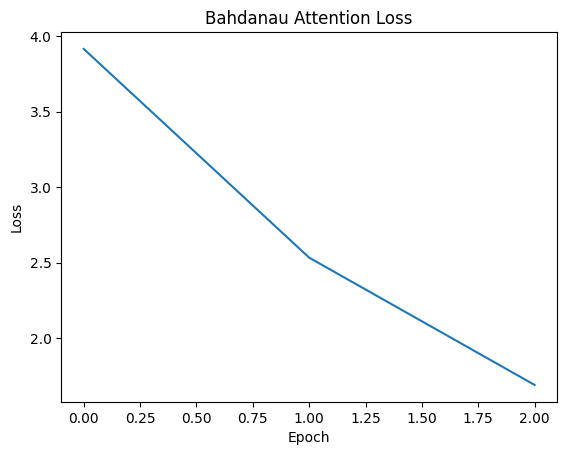

In [46]:
plt.plot(attention_losses)
plt.title("Bahdanau Attention Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [47]:
def translate_sentence(model, sentence):
    model.eval()

    tokens = [eng_vocab.stoi['<sos>']] + \
             numericalize(sentence, eng_vocab) + \
             [eng_vocab.stoi['<eos>']]

    src = torch.tensor(tokens).unsqueeze(1).to(device)

    encoder_outputs, hidden, cell = model.encoder(src)

    input = torch.tensor([spa_vocab.stoi['<sos>']]).to(device)
    outputs = []
    attentions = []

    for _ in range(20):
        output, hidden, cell, attn = model.decoder(
            input, hidden, cell, encoder_outputs
        )

        pred = output.argmax(1).item()

        if pred == spa_vocab.stoi['<eos>']:
            break

        outputs.append(spa_vocab.itos[pred])
        attentions.append(attn.squeeze(2).cpu().detach().numpy())
        input = torch.tensor([pred]).to(device)

    return outputs, attentions


In [48]:
def show_attention(sentence):
    output_words, attentions = translate_sentence(model_a, sentence)

    attn_matrix = np.concatenate(attentions, axis=1)
    input_tokens = tokenize(sentence)

    plt.figure(figsize=(10,6))
    sns.heatmap(attn_matrix,
                xticklabels=input_tokens,
                yticklabels=output_words,
                cmap="viridis")

    plt.xlabel("Input")
    plt.ylabel("Output")
    plt.title("Bahdanau Attention Heatmap")
    plt.show()


Input: fire!
Translation: ¡ fuego !


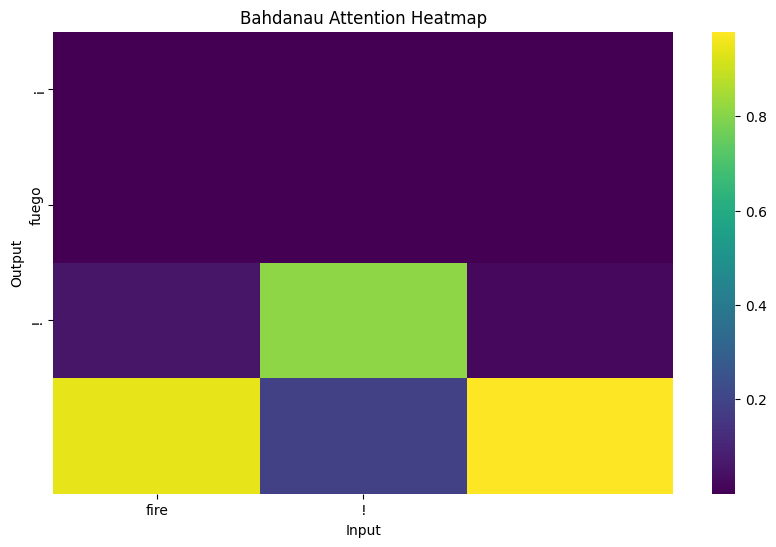

In [49]:
sentence = pairs[10][0]
print("Input:", sentence)

translation, _ = translate_sentence(model_a, sentence)
print("Translation:", " ".join(translation))

show_attention(sentence)


In [50]:
def translate_vanilla(model, sentence, max_len=20):
    model.eval()

    tokens = [eng_vocab.stoi['<sos>']] + \
             numericalize(sentence, eng_vocab) + \
             [eng_vocab.stoi['<eos>']]

    src = torch.tensor(tokens).unsqueeze(1).to(device)

    hidden, cell = model.encoder(src)

    input = torch.tensor([spa_vocab.stoi['<sos>']]).to(device)
    outputs = []

    for _ in range(max_len):
        output, hidden, cell = model.decoder(input, hidden, cell)
        pred = output.argmax(1).item()

        if pred == spa_vocab.stoi['<eos>']:
            break

        outputs.append(spa_vocab.itos[pred])
        input = torch.tensor([pred]).to(device)

    return outputs


In [51]:
def translate_attention(model, sentence, max_len=20):
    model.eval()

    tokens = [eng_vocab.stoi['<sos>']] + \
             numericalize(sentence, eng_vocab) + \
             [eng_vocab.stoi['<eos>']]

    src = torch.tensor(tokens).unsqueeze(1).to(device)

    encoder_outputs, hidden, cell = model.encoder(src)

    input = torch.tensor([spa_vocab.stoi['<sos>']]).to(device)
    outputs = []

    for _ in range(max_len):
        output, hidden, cell, _ = model.decoder(
            input, hidden, cell, encoder_outputs
        )

        pred = output.argmax(1).item()

        if pred == spa_vocab.stoi['<eos>']:
            break

        outputs.append(spa_vocab.itos[pred])
        input = torch.tensor([pred]).to(device)

    return outputs


In [55]:
from nltk.translate.bleu_score import corpus_bleu

def calculate_bleu(model, test_pairs, model_type="vanilla"):

    references = []
    candidates = []

    for src_sentence, trg_sentence in test_pairs:

        if model_type == "vanilla":
            prediction = translate_vanilla(model, src_sentence)
        else:
            prediction = translate_attention(model, src_sentence)

        references.append([tokenize(trg_sentence)])
        candidates.append(prediction)

    bleu = corpus_bleu(references, candidates)
    return bleu


In [57]:
train_size = int(0.8 * len(pairs))
val_size = int(0.1 * len(pairs))

test_pairs = pairs[train_size+val_size:]


In [58]:
bleu_v = calculate_bleu(model_v, test_pairs, "vanilla")
bleu_a = calculate_bleu(model_a, test_pairs, "attention")

print("Vanilla BLEU:", bleu_v)
print("Bahdanau BLEU:", bleu_a)


Vanilla BLEU: 0.03761065429799134
Bahdanau BLEU: 0.09900641733145234
